# Instructions

As in the previous assignment, youl'll be using PyTorch instead of EDF. This assignment will focus on generative modelling, and you'll implement and train a VAE and a GAN.

It is highly suggested to use google colab and run the notebook on a GPU node.
Check https://colab.research.google.com/ and look for tutorials online on how to use it. To use a GPU go to Runtime -> Change runtime type and select GPU.

In [1]:
%matplotlib inline
import torch, math, copy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
from scipy.stats import kde
import matplotlib.pyplot as plt

In [2]:
torch.cuda.is_available()

True

In [3]:
torch.manual_seed(0)
#torch.set_deterministic(True)
np.random.seed(0)

In this second part of the assignment you'll train a VAE and a GAN on a more interesting dataset. The cell below will try to download and load CelebA, and will just load MNIST in case there is an error.

It is likely that you'll get an error when trying to download CelebA since the its google drive is always out of quota. If you'd like to use CelebA anyway, you can try to download it from here http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html or some other source. If you're not running this notebook on a GPU then use MNIST instead.

## VAE and GANs on CelebA/MNIST

In [4]:
transform = transforms.Compose([
    transforms.Resize(64), 
    transforms.CenterCrop(64),
    transforms.ToTensor(),  
    transforms.Normalize((0.5,), (0.5,))])

In [5]:
dataset = datasets.MNIST("data", train=True, download=True, transform=transform)

In [8]:
N_IN_CHANNELS = 1 # graymap
N_CLASSES = 10
BATCH_SIZE = 32

In [68]:
LABELS = F.one_hot(torch.LongTensor(range(N_CLASSES)), N_CLASSES).cuda()

In [6]:
loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [17]:
# from google.colab.patches import cv2_imshow
import cv2

def show(x):
    img = x.data.cpu().permute(1, 2, 0).numpy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # cv2_imshow(img)
    plt.figure()
    plt.imshow(img)
    plt.show()

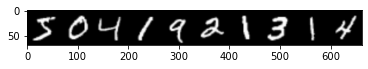

In [19]:
data = [dataset[i][0] for i in range(10)]
grid_img = torchvision.utils.make_grid(data, nrow=10, normalize=True)
show(grid_img)

We'll use a a CNN for the VAE instead of the simple model we defined previously.
Implement a network following these specifications:

- Encoder. Should have 4 conv layers, each with kernel size 4, stride 2 and padding 1, which decrease the spatial resolution by half. The output of the 4th conv (a spatial res. 4x4) should be flattened and then fully connected layers should be used to compute mu and logvar. Add whichever activation function you prefer between the conv layers (ReLU, LeakyReLU, ELU, etc), and feel free to add batch norm as well. Let the first conv layer have, say, 8 or 16 channels and then double the number of channels at each following conv layer.

- Decoder. Try to have an architecture that is roughly symmetric to the encoder. For example, start with a fully connected layer to project the latent_dim dimensional input such that you end up with a (128x4x4)-dimensional vector that you can reshape into a 4x4 image. Then you can apply 4 transposed conv layers, e.g. with kernel size 4, stride 2 and padding 1, to double the spatial resolution with each layer, having a final output of size 64x64. Start with around 64 or 128 channels for the first transposed conv and then halve the number of channels at each following conv layer. As before, add your preferred activation function between layers, with or without batch norm.

The encode, sample, and decode methods have the same specification as before.

In [64]:
class ConditionalConvVAE(nn.Module):
    def __init__(self, latent_dim, n_in_channels, n_classes):
        super(ConditionalConvVAE, self).__init__()
        self.latent_dim = latent_dim
        self.n_classes = n_classes
        
        n_channels = 16 # tuneable hyperparam
        self.n_channels = n_channels
        
        self.encoder = nn.Sequential(
            nn.Conv2d(n_in_channels + n_classes, n_channels, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(n_channels, n_channels * 2, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(n_channels * 2, n_channels * 4, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(n_channels * 4, n_channels * 8, 4, 2, 1),
            nn.Flatten()
        )
        self.flat_dim = n_channels * 8 * 4 * 4
        
        self.mu = nn.Linear(self.flat_dim, latent_dim)
        self.logvar = nn.Linear(self.flat_dim, latent_dim)
        
        self.decoder_fc = nn.Linear(latent_dim + n_classes, self.flat_dim)
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(n_channels * 8, n_channels * 4, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(n_channels * 4, n_channels * 2, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(n_channels * 2, n_channels, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(n_channels, n_in_channels, 4, 2, 1),
        )
        
    def encode(self, input):
        # implementation goes here
        x = self.encoder(input)
        mu = self.mu(x)
        logvar = self.logvar(x)
        return mu, logvar
    
    def sample(self, mu, logvar):
        # implementation goes here
        epsilon = torch.normal(0., 1., size=mu.size()).cuda()
        std = torch.exp(logvar * 0.5) 
        z = epsilon * std + mu
        return z
    
    def decode(self, input):
        # implementation goes here
        out = self.decoder_fc(input)
        out = out.reshape(-1, self.n_channels * 8, 4, 4)
        out = self.decoder(out)
        return out
        
    def forward(self, x, y):
        """
        y must be one-hot
        """
        # add n_classes as additional channels
        # num_per_batch x n_classes x 1 x 1
        channels = y.unsqueeze(-1).unsqueeze(-1).repeat(1, 1, x.shape[-2], x.shape[-1])
        x = torch.cat((x, channels), dim=1)
        
        mu, logvar = self.encode(x)
        z = self.sample(mu, logvar)
        z = torch.cat((z, y), dim=1)
        
        out = self.decode(z)
        return mu, logvar, out
    
    def generate(self, n, y):
        """
        y must be one-hot and be of length n
        """
        z = torch.randn(n, self.latent_dim).cuda()
        z = torch.cat((z, y), dim=1)
        samples = self.decode(z)
        return samples

In [65]:
def loss(x, out, mu, logvar, beta, sigma=1):
    # implementation goes here
    recons_loss = ((out - x) * (out - x)).sum()
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    loss = recons_loss + beta * kld_loss
    return recons_loss, kld_loss, loss

In [69]:
vae = ConditionalConvVAE(100, N_IN_CHANNELS, N_CLASSES).cuda()
opt = torch.optim.Adam(vae.parameters(), lr=5e-4)

The cell below applies a 'patch' in case you're using google colab (cv2_imshow doesn't work properly on google colab without it). Feel free to comment out the first import if you're not using google colab (you might have to add from cv2 import cv2_imshow, though).

Again, try to find a value for beta that yields reasonable results.

recons_loss 138661.21875, kld_loss 0.8533934950828552


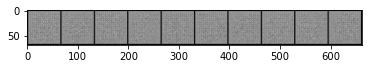

recons_loss 2889.908203125, kld_loss 2156.359619140625


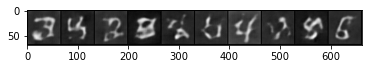

recons_loss 1898.22265625, kld_loss 2013.1351318359375


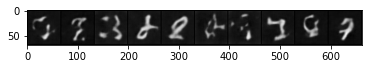

recons_loss 1918.2850341796875, kld_loss 2031.514892578125


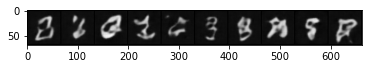

recons_loss 1639.2962646484375, kld_loss 1795.3114013671875


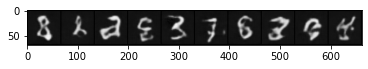

recons_loss 1522.28076171875, kld_loss 2037.0244140625


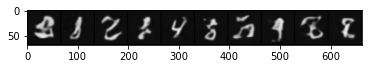

recons_loss 1400.992431640625, kld_loss 1828.527099609375


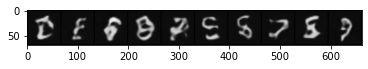

recons_loss 1272.2939453125, kld_loss 1679.92529296875


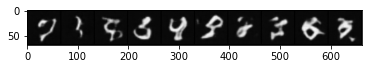

recons_loss 1332.55029296875, kld_loss 1894.531982421875


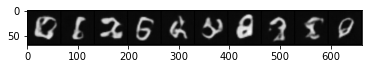

recons_loss 1403.143310546875, kld_loss 1874.970947265625


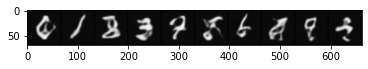

recons_loss 1529.99755859375, kld_loss 1877.228271484375


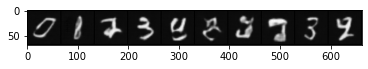

recons_loss 1702.5875244140625, kld_loss 1824.28564453125


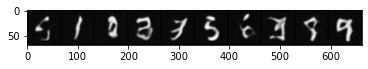

recons_loss 1384.5660400390625, kld_loss 1777.3114013671875


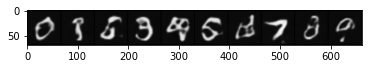

recons_loss 1543.82080078125, kld_loss 1767.8436279296875


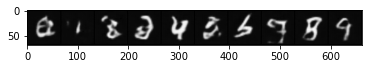

In [ ]:
beta = 0.9
for epoch in range(30):
    for i, (x, y) in enumerate(loader):
        x = x.cuda()
        # y: one-hot labels
        y = F.one_hot(y, N_CLASSES).cuda()
        
        mu, logvar, out = vae(x, y)
        rl, kl, l = loss(x, out, mu, logvar, beta)

        opt.zero_grad()
        l.backward()
        opt.step()
        if i == 0:
            print('recons_loss {}, kld_loss {}'.format(rl.item(), kl.item()))
            vae.eval()
            data = vae.generate(10, LABELS)
            grid_img = torchvision.utils.make_grid(data, nrow=10, normalize=True)
            show(grid_img)
            vae.train()